In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import sys
work_path='/Volumes/Data/Onedrive/Work/nike/'
sys.path.append(work_path)
import scipy.interpolate
from lib.histdist import distance_to_edge, distfit, model6, reduce_samples 

# mass-radius diagram

(2.5, 20.0)

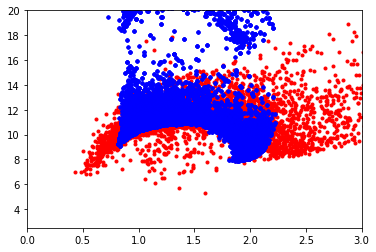

In [2]:
yu = np.load(work_path+'sample/heb/yu_nc/yu18.npy',allow_pickle=True).tolist()
edge = np.load(work_path+'sample/heb/yu_nc/mr_edge_samples.npy')
tck_obs, tp_obs = np.load(work_path+"sample/heb/yu_nc/mr_spline_tck.npy", allow_pickle=True)
xobs, yobs = yu["mass"], yu["radius"]
idx = edge[:,0]<3.0
xedge_obs, yedge_obs = edge[:,0][idx], edge[:,1][idx]

pdv = np.load(work_path+'sample/heb/padova/padova.npy',allow_pickle=True).tolist()
edge = np.load(work_path+'sample/heb/padova/mr_edge_samples.npy')
tck_pdv, tp_pdv = np.load(work_path+'sample/heb/padova/mr_spline_tck.npy', allow_pickle=True)
xpdv, ypdv = pdv["mass"], pdv["radius"]
idx = edge[:,0]<3.0
xedge_pdv, yedge_pdv = edge[:,0][idx], edge[:,1][idx]

plt.plot(xobs, yobs, 'r.')
plt.plot(xpdv, ypdv, 'b.')
plt.xlim(0., 3.0)
plt.ylim(2.5, 20.)

sigma,  0.24087071686765088
Nstar,  4918
perturb,  0.0034347073777999584
sigma,  0.07997707917856642
Nstar,  1738
perturb,  0.0019184065708195352


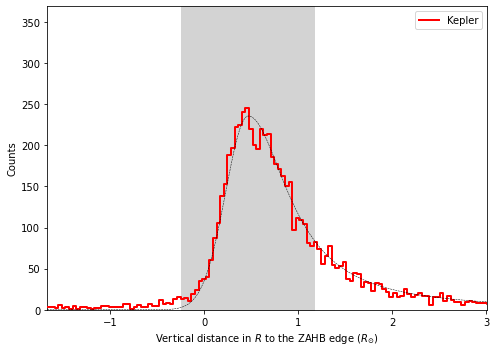

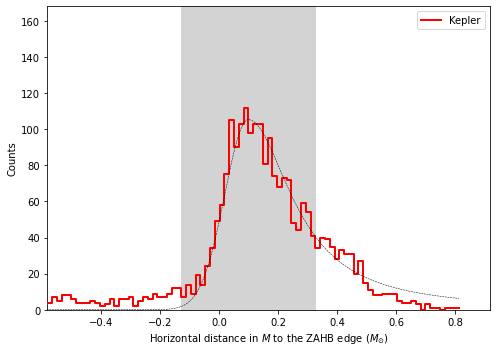

In [3]:
def plot_model(distance, tck_obs, tp_obs, xobs, yobs, xedge_obs, yedge_obs):
    # calculate Kepler distance
    hdist_obs, xobs, yobs = distance_to_edge(xobs, yobs, xedge_obs, yedge_obs, tck_obs, tp_obs, diagram=diagram, distance=distance)
    obj_obs = distfit(hdist_obs, hist_model)
    obj_obs = distfit(hdist_obs, hist_model, bins=obj_obs.bins)
    obj_obs.fit(ifmcmc=False)

    # tied to model6
    weight = np.zeros(obj_obs.histx.shape[0], dtype=bool)
    sigma, x0 = obj_obs.para_fit[0], obj_obs.para_fit[1]
    idx = (obj_obs.histx >= x0-3*sigma) & (obj_obs.histx <= x0+3*sigma)
    weight[idx] = True
    
    
    # result plot
    fig = plt.figure(figsize=(7,5))
    axes = fig.subplots(nrows=1, ncols=1, squeeze=False).reshape(-1)
    obj_obs.plot_hist(ax=axes[0], histkwargs={"color":"red","linewidth":2.0,"label":"Kepler", "zorder":100})
    obj_obs.plot_fit(ax=axes[0], fitkwargs={"color":"black","linewidth":0.5, "linestyle":"--", "zorder":100})
    
    # axes[0].grid(True)
    axes[0].set_ylim(0., obj_obs.histy.max()*1.5)
    axes[0].set_xlabel(xtitle)
    axes[0].set_ylabel("Counts")
    axes[0].legend()
    # fill weighted region
    xmin_, xmax_ = obj_obs.histx[weight].min(), obj_obs.histx[weight].max()
    lr = xmax_ - xmin_
    axes[0].fill_betweenx(axes[0].get_ylim(), [xmin_, xmin_], [xmax_, xmax_], color="lightgray")
    axes[0].set_xlim(xmin_-lr*1.0, xmax_+lr*1.3)
    
    print('sigma, ', sigma)
    print('Nstar, ', np.sum(obj_obs.histy[weight]))
    print('perturb, ', sigma/np.sqrt(np.sum(obj_obs.histy[weight])) )

    # plt.show()
    plt.tight_layout()
    # plt.close()
    return
    

diagram = "mr"
hist_model = model6()
distance = "vertical"
xtitle = "Vertical distance in $R$ to the ZAHB edge ($R_{\odot}$)"
plot_model(distance, tck_obs, tp_obs, xobs, yobs, xedge_obs, yedge_obs)


diagram = "mr"
hist_model = model6()
distance = "horizontal"
xtitle = "Horizontal distance in $M$ to the ZAHB edge ($M_{\odot}$)"
plot_model(distance, tck_obs, tp_obs, xobs, yobs, xedge_obs, yedge_obs)

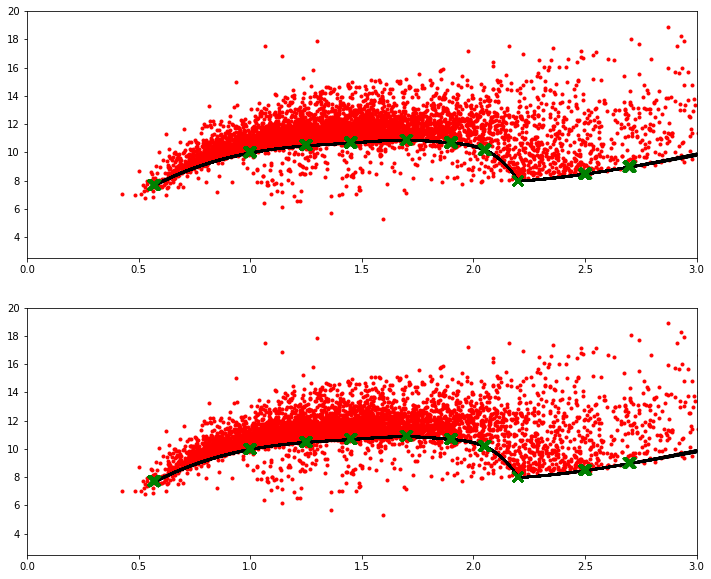

In [4]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(12,10), squeeze=False)
axes = axes.reshape(-1)

for ax in axes:
    ax.plot(xobs, yobs, 'r.')
    ax.set_xlim(0., 3.0)
    ax.set_ylim(2.5, 20.)

points1=[(0.57, 7.7), (1.0, 10.0), (1.25, 10.5), (1.45, 10.7), (1.7, 10.9), (1.9, 10.7), (2.05, 10.2), (2.2, 8.0)]
points2=[(2.2, 8.0), (2.5, 8.5), (2.7, 9.0), (4.0, 12)]
points = [points1, points2]
tp = (2.2, 8.0)

perturbs_mass = 0.0019 # 0.0473/5. #
perturbs_radius = 0.0034 # 0.057/5. #
Npert = 300

perturb_data = []
for ipert in range(Npert):
#     print(ipert)
    # cubic spline interpolation
    # points
    tcks = []
    xmin = min(np.array([points[0][i][0] for i in range(len(points[0]))]).min(), np.array([points[1][i][0] for i in range(len(points[1]))]).min())
    xmax = max(np.array([points[0][i][0] for i in range(len(points[0]))]).max(), np.array([points[1][i][0] for i in range(len(points[1]))]).max())
    xedge = np.arange(xmin, xmax, 0.0005)
    yedge = np.zeros(len(xedge))
    idx = [xedge<tp[0], xedge>=tp[0]]
    for j, point in enumerate(points):
        Npoint = len(point)
        xpoint = np.array([point[i][0] for i in range(Npoint)])+np.random.randn(Npoint)*perturbs_mass
        ypoint = np.array([point[i][1] for i in range(Npoint)])+np.random.randn(Npoint)*perturbs_radius
        if j==0: xpoint[-1], ypoint[-1] = tp[0], tp[1]
        if j==1: xpoint[0], ypoint[0] = tp[0], tp[1]
#         xpoint = np.array([point[i][0] for i in range(Npoint)])
#         ypoint = np.array([point[i][1] for i in range(Npoint)])
        tck = scipy.interpolate.splrep(xpoint, ypoint, s=0)
        tcks.append(tck)

        # plot knots and edge 
        #if ifplot:
        #    axes[0].plot(xpoint, ypoint, "k.", markersize=10)
        #    axes[1].plot(xpoint, ypoint, "k.", markersize=10)
        axes[0].plot(xpoint, ypoint, "gx", markersize=10,markeredgewidth=2,zorder=100)
        axes[1].plot(xpoint, ypoint, "gx", markersize=10,markeredgewidth=2,zorder=100)
        yedge[idx[j]] = scipy.interpolate.splev(xedge[idx[j]], tck, der=0)

    # if ifplot:
    axes[0].plot(xedge, yedge, "k.", ms=0.2, zorder=10) 
    axes[1].plot(xedge, yedge, "k.", ms=0.2, zorder=10) 
    
    perturb_data.append([np.array([xedge, yedge]).T, tcks, tp])

np.save(work_path+'sample/heb/yu_nc/mr_perturb_data.npy', perturb_data)

# dnu-numax diagram

(0.0, 10.0)

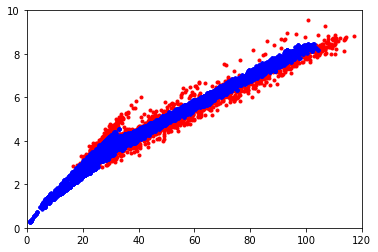

In [5]:
yu = np.load(work_path+'sample/heb/yu_nc/yu18.npy',allow_pickle=True).tolist()
edge = np.load(work_path+'sample/heb/yu_nc/tnu_edge_samples.npy')
tck_obs, tp_obs = np.load(work_path+"sample/heb/yu/nike_spline_tck.npy", allow_pickle=True)
xobs, yobs = yu["numax"], yu["dnu"]
xedge_obs, yedge_obs = edge[:,0], edge[:,1]

pdv = np.load(work_path+'sample/heb/padova/padova.npy',allow_pickle=True).tolist()
edge = np.load(work_path+'sample/heb/padova/tnu_edge_samples.npy')
tck_pdv, tp_pdv = np.load(work_path+'sample/heb/padova/nike_spline_tck.npy', allow_pickle=True)
xpdv, ypdv = pdv["numax"], pdv["dnu"]
xedge_pdv, yedge_pdv = edge[:,0], edge[:,1]

plt.plot(xobs, yobs, 'r.')
plt.plot(xpdv, ypdv, 'b.')
plt.xlim(0., 120.0)
plt.ylim(0., 10.)

sigma,  0.06942971934203908
Nstar,  3746
perturb,  0.0011343877373654395
sigma,  1.4078084881286739
Nstar,  2190
perturb,  0.030083026200993377


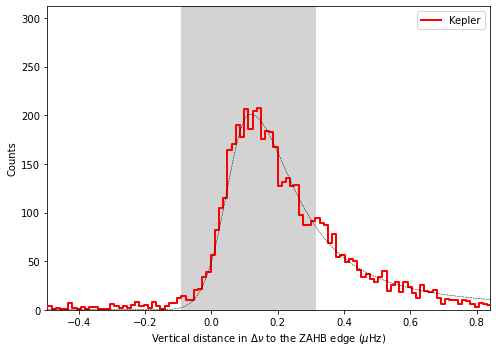

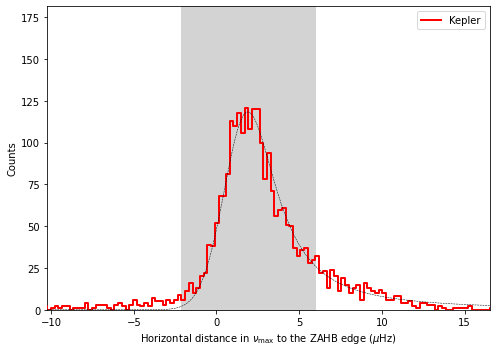

In [6]:
def plot_model(distance, tck_obs, tp_obs, xobs, yobs, xedge_obs, yedge_obs):
    # calculate Kepler distance
    hdist_obs, xobs, yobs = distance_to_edge(xobs, yobs, xedge_obs, yedge_obs, tck_obs, tp_obs, diagram=diagram, distance=distance)
    obj_obs = distfit(hdist_obs, hist_model)
    obj_obs = distfit(hdist_obs, hist_model, bins=obj_obs.bins)
    obj_obs.fit(ifmcmc=False)

    # tied to model6
    weight = np.zeros(obj_obs.histx.shape[0], dtype=bool)
    sigma, x0 = obj_obs.para_fit[0], obj_obs.para_fit[1]
    idx = (obj_obs.histx >= x0-3*sigma) & (obj_obs.histx <= x0+3*sigma)
    weight[idx] = True
    
    
    # result plot
    fig = plt.figure(figsize=(7,5))
    axes = fig.subplots(nrows=1, ncols=1, squeeze=False).reshape(-1)
    obj_obs.plot_hist(ax=axes[0], histkwargs={"color":"red","linewidth":2.0,"label":"Kepler", "zorder":100})
    obj_obs.plot_fit(ax=axes[0], fitkwargs={"color":"black","linewidth":0.5, "linestyle":"--", "zorder":100})
    
    # axes[0].grid(True)
    axes[0].set_ylim(0., obj_obs.histy.max()*1.5)
    axes[0].set_xlabel(xtitle)
    axes[0].set_ylabel("Counts")
    axes[0].legend()
    # fill weighted region
    xmin_, xmax_ = obj_obs.histx[weight].min(), obj_obs.histx[weight].max()
    lr = xmax_ - xmin_
    axes[0].fill_betweenx(axes[0].get_ylim(), [xmin_, xmin_], [xmax_, xmax_], color="lightgray")
    axes[0].set_xlim(xmin_-lr*1.0, xmax_+lr*1.3)
    
    print('sigma, ', sigma)
    print('Nstar, ', np.sum(obj_obs.histy[weight]))
    print('perturb, ', sigma/np.sqrt(np.sum(obj_obs.histy[weight])) )

    # plt.show()
    plt.tight_layout()
    # plt.close()
    return
    

diagram = "tnu"
hist_model = model6()
distance = "vertical"
xtitle = "Vertical distance in $\\Delta\\nu$ to the ZAHB edge ($\\mu$Hz)"
plot_model(distance, tck_obs, tp_obs, xobs, yobs, xedge_obs, yedge_obs)


diagram = "tnu"
hist_model = model6()
distance = "horizontal"
xtitle = "Horizontal distance in $\\nu_{\\rm max}$ to the ZAHB edge ($\\mu$Hz)"
plot_model(distance, tck_obs, tp_obs, xobs, yobs, xedge_obs, yedge_obs)

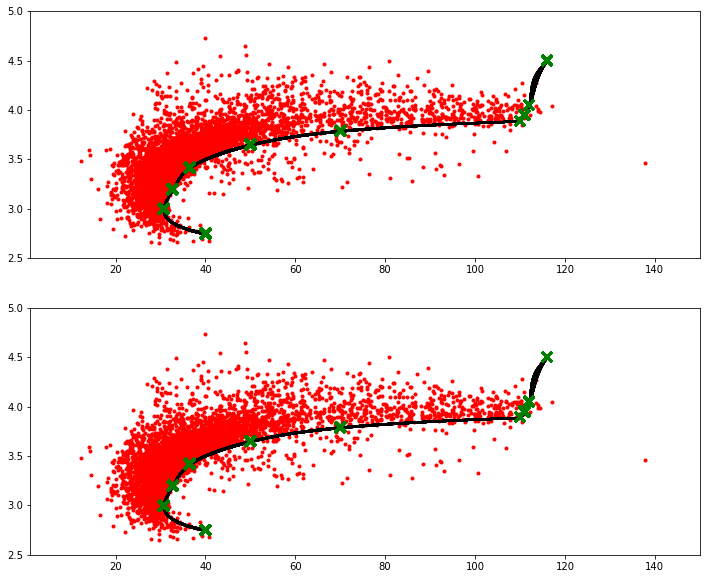

In [7]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(12,10), squeeze=False)
axes = axes.reshape(-1)

for ax in axes:
    ax.plot(xobs, xobs**0.75/yobs, 'r.')
    ax.set_xlim(1., 150.0)
    ax.set_ylim(2.5, 5.)

points1=[(40, 2.75), (30.7, 3.0), (32.7, 3.2), (36.5, 3.42), (50, 3.65), (70, 3.79),  (110, 3.89)]
points2=[(110, 3.89), (111, 3.95), (112, 4.05), (116, 4.5)]
points=[points1,points2]
tp= (110, 3.89)

perturbs_dnu = 0.00113#0.036/5
perturbs_numax = 0.03008 #0.166/5
Npert = 300

perturb_data = []
for ipert in range(Npert):
#     print(ipert)
    # cubic spline interpolation
    # points
    tcks = []
    ymin = min(np.array([points[0][i][1] for i in range(len(points[0]))]).min(), np.array([points[1][i][1] for i in range(len(points[1]))]).min())
    ymax = max(np.array([points[0][i][1] for i in range(len(points[0]))]).max(), np.array([points[1][i][1] for i in range(len(points[1]))]).max())
    yedge = np.arange(ymin, ymax, 0.0001) # nike
    xedge = np.zeros(len(yedge)) # numax
    idx = [yedge<tp[1], yedge>=tp[1]]
    for j, point in enumerate(points):
        Npoint = len(point)
        xnumax = np.array([point[i][0] for i in range(Npoint)])#+np.random.randn(Npoint)*perturbs_numax
        ynike = np.array([point[i][1] for i in range(Npoint)])#+np.random.randn(Npoint)*perturbs_dnu
        ydnu = xnumax**0.75/ynike
        xnumax = xnumax + np.random.randn(Npoint)*perturbs_numax
        ydnu = ydnu + np.random.randn(Npoint)*perturbs_dnu
        xpoint = xnumax
        ypoint = xnumax**0.75/ydnu
        
        if j==0: xpoint[-1], ypoint[-1] = tp[0], tp[1]
        if j==1: xpoint[0], ypoint[0] = tp[0], tp[1]
#         xpoint = np.array([point[i][0] for i in range(Npoint)])
#         ypoint = np.array([point[i][1] for i in range(Npoint)])
        tck = scipy.interpolate.splrep(np.log10(ypoint), np.log10(xpoint), s=0)
        tcks.append(tck)

        # plot knots and edge 
        #if ifplot:
        #    axes[0].plot(xpoint, ypoint, "k.", markersize=10)
        #    axes[1].plot(xpoint, ypoint, "k.", markersize=10)
        axes[0].plot(xpoint, ypoint, "gx", markersize=10,markeredgewidth=2,zorder=100)
        axes[1].plot(xpoint, ypoint, "gx", markersize=10,markeredgewidth=2,zorder=100)
        xedge[idx[j]] = 10.0**scipy.interpolate.splev(np.log10(yedge[idx[j]]), tck, der=0)

    # if ifplot:
    
#     axes[0].plot(xedge, yedge, "k.", ms=0.2, zorder=10) 
#     axes[1].plot(xedge, yedge, "k.", ms=0.2, zorder=10) 
    yedge = xedge**0.75/yedge # dnu
    axes[0].plot(xedge, xedge**0.75/yedge, "k.", ms=0.2, zorder=10) 
    axes[1].plot(xedge, xedge**0.75/yedge, "k.", ms=0.2, zorder=10) 
    
    perturb_data.append([np.array([xedge, yedge]).T, tcks, tp])

np.save(work_path+'sample/heb/yu_nc/tnu_perturb_data.npy', perturb_data)